## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: It's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious  scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

In [1]:
# library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np    
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report,plot_roc_curve
from sklearn import metrics

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [2]:
df = pd.read_csv('./chronic_kidney_disease_full.csv')

In [3]:
# The features

df.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

In [4]:
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


In [5]:
df.shape

(400, 25)

In [6]:
# create dummy variable for all of object type variable. 
df_dummy = pd.get_dummies(df,drop_first=True)

In [7]:
df_dummy.head()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,...,pc_normal,pcc_present,ba_present,htn_yes,dm_yes,cad_yes,appet_poor,pe_yes,ane_yes,class_notckd
0,48.0,80.0,1.020,1.0,0.0,121.0,36.0,1.2,NaN,NaN,...,1,0,0,1,1,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,NaN,18.0,0.8,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,423.0,53.0,1.8,NaN,NaN,...,1,0,0,0,1,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,117.0,56.0,3.8,111.0,2.5,...,0,1,0,1,0,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,106.0,26.0,1.4,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [8]:
df_dummy.shape

(400, 25)

In [9]:
# The majority class of this data is people who are CKD, which is the baseline.
df_dummy['class_notckd'].value_counts(normalize=True)

0    0.625
1    0.375
Name: class_notckd, dtype: float64

## Feature engineering

In [10]:
# Seeking the median difference values between the target classes in each features.

class_feature = df_dummy.groupby('class_notckd').median().T
class_feature['diff'] = abs(class_feature[0]-class_feature[1])

In [11]:
# Sort only the median difference equal or more than 1
class_feature[class_feature['diff'] >=1 ].sort_values(by='diff',ascending=False)

class_notckd,0,1,diff
wbcc,8800.00,7500.0,1300.00
bgr,143.50,107.5,36.00
bu,53.00,33.0,20.00
age,59.00,46.0,13.00
pcv,33.00,46.0,13.00
bp,80.00,70.0,10.00
sod,136.00,141.0,5.00
hemo,10.90,15.0,4.10
al,2.00,0.0,2.00
rbcc,3.90,5.3,1.40


In [12]:
# List of features that have median difference equal or more than 1
class_feature[class_feature['diff'] >=1 ].sort_values(by='diff',ascending=False).index

Index(['wbcc', 'bgr', 'bu', 'age', 'pcv', 'bp', 'sod', 'hemo', 'al', 'rbcc',
       'sc', 'rbc_normal', 'pc_normal', 'htn_yes', 'dm_yes'],
      dtype='object')

In [13]:
# Seeking the correlation of all features
df_dummy.corr()[['class_notckd']].sort_values(by='class_notckd',ascending=False)

,class_notckd
class_notckd,1.000000
hemo,0.768919
pcv,0.741427
sg,0.732163
rbcc,0.699089
rbc_normal,0.677781
pc_normal,0.474244
sod,0.375674
pot,-0.084541
ba_present,-0.186871


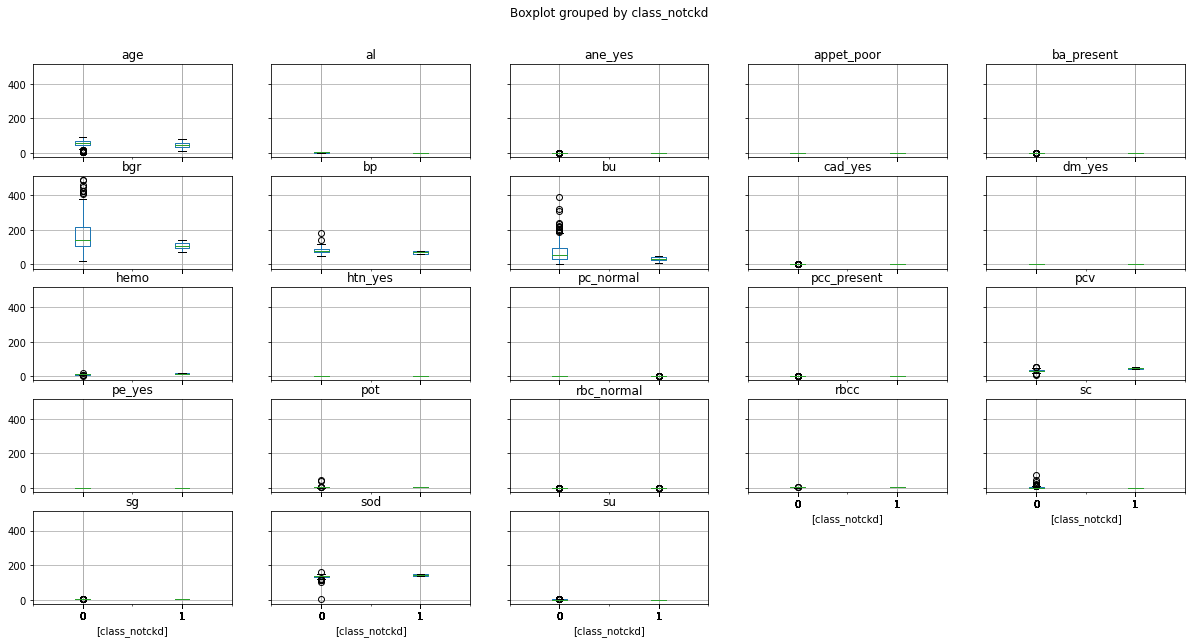

In [14]:
# Seeking in the overview sight. 
# Not seeing much different.
fig ,ax = plt.subplots(figsize=(20,10))
df_dummy.drop(columns='wbcc').boxplot(by='class_notckd',ax = ax);

<AxesSubplot: xlabel='class_notckd', ylabel='al'>

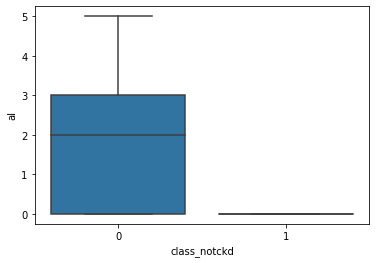

In [15]:
# Scope in 'albumin' feature, we see significant difference
sns.boxplot(df_dummy['class_notckd'],df_dummy['al'])

### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

### Feature selection from correlation and median differences

- From correlation : 
'hemo', 'pcv', 'sg', 'rbcc', 'rbc_normal', 'pc_normal','bgr','dm_yes', 'htn_yes', 'al','e_yes','sod','bu','appet_poor'
- From mean diff :
'wbcc', 'bgr', 'bu', 'age', 'pcv', 'bp', 'sod', 'hemo', 'al', 'rbcc','sc', 'rbc_normal', 'pc_normal', 'htn_yes', 'dm_yes'

#### the intersect
- `'hemo','pcv','rbcc','rbc_normal','pc_normal','dm_yes','htn_yes','al','sod','bu'`

Answer:
'hemo','pcv','rbcc','rbc_normal','pc_normal','dm_yes','htn_yes','al','sod','bu'

al : chronic kidney disease (CKD) patients with a low serum albumin have an increased risk for reaching kidney failue

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [16]:
# The original data
df.isnull().sum().sort_values()

class      0
pe         1
appet      1
ane        1
cad        2
dm         2
htn        2
pcc        4
ba         4
age        9
bp        12
sc        17
bu        19
bgr       44
al        46
sg        47
su        49
hemo      52
pc        65
pcv       71
sod       87
pot       88
wbcc     106
rbcc     131
rbc      152
dtype: int64

In [17]:
# The selected features data
df_dummy[['hemo','pcv','rbcc','rbc_normal','pc_normal','dm_yes','htn_yes','al','sod','bu','class_notckd']].isnull().sum().sort_values()

rbc_normal        0
pc_normal         0
dm_yes            0
htn_yes           0
class_notckd      0
bu               19
al               46
hemo             52
pcv              71
sod              87
rbcc            131
dtype: int64

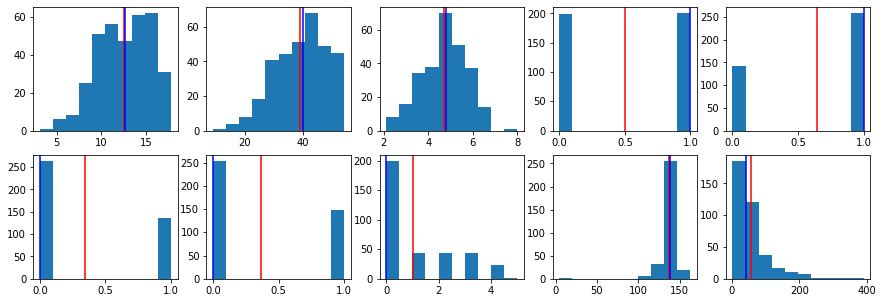

In [18]:
# Visualization the distribution in each features.
# Find the optimal value to fill the missing values in each feature.

fig,ax = plt.subplots(2,5,figsize=(15,5))
for col,item in zip(['hemo','pcv','rbcc','rbc_normal','pc_normal','dm_yes','htn_yes','al','sod','bu'],ax.ravel()):
    item.hist(df_dummy[col])
    item.axvline(df_dummy[col].mean() ,color='r') # mean
    item.axvline(df_dummy[col].median() ,color='b') #median
    

In [19]:
for col in ['hemo','pcv','rbcc','rbc_normal','pc_normal','dm_yes','htn_yes','al','sod','bu']:
    df_dummy[col].fillna(df_dummy[col].median(),inplace=True)
    
# All features may use median to fill the missing values.

In [119]:
print('-------------------- people with NON - CKD --------------------')
print(df_dummy[df_dummy.class_notckd==0][['al']].describe().T)
print('\n\n-------------------- people with CKD --------------------')
print(df_dummy[df_dummy.class_notckd==1][['al']].describe().T)


# As you can see the al feature has significant difference of mean between NON-CKD and CKD person.

-------------------- people with NON - CKD --------------------
    count  mean       std  min  25%  50%  75%  max
al  250.0  1.44  1.407952  0.0  0.0  1.0  3.0  5.0


-------------------- people with CKD --------------------
    count  mean  std  min  25%  50%  75%  max
al  150.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0


### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

Answer: The data will remain 158 rows. 

1. The first downside of doing this is the sample size of training the model will decreased, so it would make the reliability of the model low .

2. The Second downside is it will cause the higher of imbalance scenario

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

In [20]:
df.groupby('class')['rbc'].value_counts(dropna=False)

class   rbc     
ckd     NaN         143
        normal       60
        abnormal     47
notckd  normal      141
        NaN           9
Name: rbc, dtype: int64

Answer: 
- Assume that doctors and nurses are professional and experienced
1. The higher of missing values mean not important to diagnose the disease, so the patients that have shown obvious symptom of CKD doctors might not searching a lot of  things. That make some of data loss.
2. The doctors prefer to use the urine test before blood test. As you can see from above the NaN values of rbc in CKD patients loss much than notckd patients. This mean that doctor has diagnose the patient to be ckd before testing the number of blood cell.
3. It's the privilege of patients. Some process need to working on patients body e.g. measuring the blood cell.



---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has chronic kidney disease (CKD) will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer: 

For the classification problem, we need to defin what we want to observe. 
- Let person with CKD = 1 (positive), and person without CKD = 0 (negative)

From the confusion matrix to evaluate the model, if we want the model to predict 100% correct (person with CKD, will
always be told to be CKD). This mean we would like to the number of predicting false in person who has CKD, which state as False negative 'FN' in confusion matrix.

Everything has tradeoff, when reducing the 'FN' by adjusting the thresehold or optimization the model there will be increased in opposite term which is Fasle positive 'FP'.

Thus, if the increasing of 'FP' mean that the model predicting a lot of false in positive case, in other word is the model tell every suspected person to be CKD, no matter the person is CKD or not. 

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: Confusion matrix, we minimize the false negative

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer: The disvantage is the person who got wrong CKD result will got an high anxiety and may cause in health effect in the long term.

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer: This model is conversely from the problem6. The model tend to reduce False positive, in other word is we want to tell all of people who don't have CKD 100% corrected. So, the reducing in False positive will increase the False negative.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer: confusion matrix, we minimize false positive (maximizing specificity)

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer: The disadvantage is there will be increased of number of person who has CKD but didn't diagnose and treat by doctors and that will lead to death of a bunch of people.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [126]:
# Set X,y
X_full = df_dummy[['hemo','pcv','rbcc','rbc_normal','pc_normal','dm_yes','htn_yes','sod']]
y_full = df_dummy['class_notckd']

# split data 
X_full_train,X_full_test,y_full_train,y_full_test = train_test_split(X_full,y_full,random_state=42)

# Instantiate
logreg_full = LogisticRegression(penalty = 'none')
# Fit
logreg_full.fit(X_full_train,y_full_train)
# Predict
preds_full = logreg_full.predict(X_full_test)

print(f'Train: {logreg_full.score(X_full_train,y_full_train)}')
print(f'Test: {logreg_full.score(X_full_test,y_full_test)}')
# Very great accuracy model

Train: 0.99
Test: 0.98


In [129]:
# Let's see what if take out 2 correlated coefficients

In [130]:
# Set X,y and split
X = df_dummy[['hemo','pcv','rbcc','rbc_normal','pc_normal','dm_yes']]
y = df_dummy['class_notckd']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [131]:
# check shape
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((300, 6), (100, 6), (300,), (100,))

In [132]:
# Instantiate
logreg = LogisticRegression(penalty = 'none')
# Fit
logreg.fit(X_train,y_train)
# Predict
preds = logreg.predict(X_test)
# Score
print(f'Train: {logreg.score(X_train,y_train)}')
print(f'Test: {logreg.score(X_test,y_test)}')

# lower the variance of the model a bit.

Train: 0.9866666666666667
Test: 0.98


---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [133]:
logreg_coef = pd.DataFrame(logreg_full.coef_,columns=logreg_full.feature_names_in_).T

In [263]:
logreg_coef.rename(columns={0:'coefficient'},inplace=True)
logreg_coef.sort_values(by='coefficient')
# take exponent to make it easy to interpret
np.exp(logreg_coef).round(2)

,coefficient
hemo,29.48
pcv,1.06
rbcc,19.32
rbc_normal,19551.21
pc_normal,2.93
dm_yes,0.00
htn_yes,0.00
sod,1.04


- hemo : The higher in hemoglobin may indicate to the higher rate not to be CKD.
- As hemo increased by 1, the person is about 178.2 times as likely to not being CKD.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

- htn_yes : The higher of hypertension, the higher rate to be CDK. The coefficient said that if the person with no hypertension will lead to not being CDK.
    
When your blood pressure decreases it indicates that there is a change in blood flow throughout the body. 
A change in blood flow can cause a serious problems with the kidneys because there is a dramatic decrease in blood flow to the kidneys.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:

1. logistic regression is parametic model, which has coefficient to explain the scenarios that happen with the target variable
2. logistic regression has no assumption like LINEM, so it is easy to use.

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

- We have to generate the confusion matrix on test data, because the purpose of doing this is to evaluate the model. So, we want to see the performance of model working on 'Unseen data' which is test data.

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.97      0.97      0.97        35

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



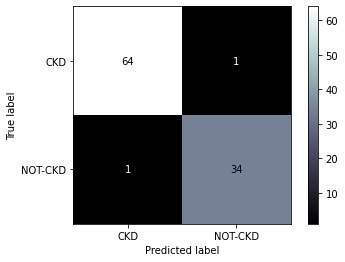

In [192]:
plot_confusion_matrix(logreg_full,X_full_test,y_full_test,display_labels=['CKD','NOT-CKD'],cmap='bone')
print(metrics.classification_report(y_full_test,preds_full))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.97      0.97      0.97        35

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



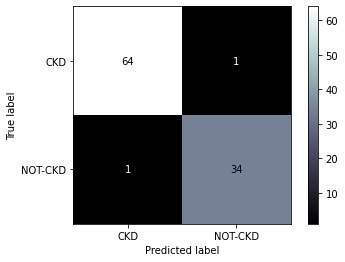

In [138]:
plot_confusion_matrix(logreg,X_test,y_test,display_labels=['CKD','NOT-CKD'],cmap='bone')
print(metrics.classification_report(y_test,preds))

In [ ]:
# Two model are perform equally.

### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer: In this model, we need to optimize sensitivity. Because, we want to predict all of the person with CKD. 
So the increase in sensitity will less on the False negative which mean lower on predicting fail CKD person.


### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [139]:
# Predict the prob. from test data - first model
prob_pred_full = logreg_full.predict_proba(X_full_test)

# Predict the prob. from test data - second model
prob_pred = logreg.predict_proba(X_test)

In [140]:
# create data frame prob class with the column of CKD and non CKD
prob_class = pd.DataFrame(data = prob_pred_full,columns=['prob_CKD_full','prob_NOT_CKD_full'])

In [141]:
prob_class[['prob_CKD','prob_NOT_CKD']] = prob_pred

In [142]:
# create new column of real results of patient 
prob_class['true_not_ckd'] = y_full_test

In [143]:
# 1 are missing. fill missing values in new column
prob_class['true_not_ckd'].fillna(1,inplace=True)

In [144]:
prob_class.head()

,prob_CKD_full,prob_NOT_CKD_full,prob_CKD,prob_NOT_CKD,true_not_ckd
0,0.999999,1.315330e-06,1.000000,4.149877e-07,0.0
1,0.998368,1.632097e-03,0.990268,9.732362e-03,1.0
2,1.000000,3.096551e-46,1.000000,5.630384e-11,1.0
3,1.000000,5.937326e-83,1.000000,1.561445e-37,0.0
4,1.000000,1.746812e-85,1.000000,2.031644e-38,1.0


In [145]:
# set threshold at 0
# if the prob. of predicting is more than 0 it will result in not CKD
thres_full  = [1 if x > 0 else 0 for x in prob_class['prob_NOT_CKD_full'] ]

In [146]:
cm_full = confusion_matrix(y_full_test,thres_full)
cm_full

array([[ 0, 65],
       [ 0, 35]])

In [147]:
tn_full, fp_full, fn_full, tp_full = cm_full.ravel()

In [148]:
# specificity = tn / tn+fp
print(tn_full / (tn_full+fp_full))
# sensitivity = tp / tp+fn
print(tp_full / (tp_full+fn_full))
# 1-sensitivity
print(1-(tp_full / (tp_full+fn_full)))

0.0
1.0
0.0


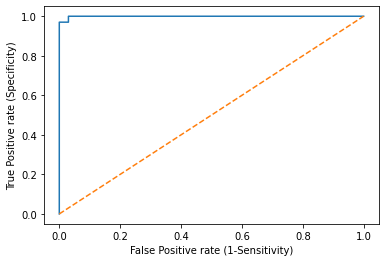

In [149]:
# First model

# observe the sensitivity and specificity from threshold 0 - 1 step by 0.00001
sensitivity_full = []
specificity_full = []

for i in np.arange(0,1.0001,0.00001):
#     adjust threshold
    thres_full  = [1 if x >= i else 0 for x in prob_class['prob_NOT_CKD_full']]
    cm_full = confusion_matrix(y_full_test,thres_full)
    tn_full, fp_full, fn_full, tp_full = cm_full.ravel()
    sensitivity_full.append((tn_full / (tn_full+fp_full)).round(2))                 
    specificity_full.append((tp_full / (tp_full+fn_full)).round(2))
# new list : 1 - sensitivity
sen_1_full  = [1-x for x in sensitivity_full] 
# Plot ROC curve
plt.plot(sen_1_full,specificity_full)
# Plot baseline
plt.plot([0,1], [0,1], label='baseline', linestyle='--')
plt.xlabel('False Positive rate (1-Sensitivity)')
plt.ylabel('True Positive rate (Specificity)');


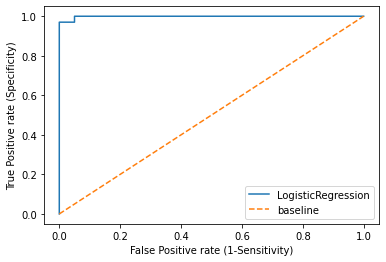

In [150]:
# Second model

# observe the sensitivity and specificity from threshold 0 - 1 step by 0.0001
sensitivity = []
specificity = []
for j in np.arange(0,1.0001,0.0001):
    thres  = [1 if x >= j else 0 for x in prob_class['prob_NOT_CKD']]
    cm = confusion_matrix(y_test,thres)
    tn, fp, fn, tp = cm.ravel()
    sensitivity.append((tn / (tn+fp)).round(2))                 
    specificity.append((tp / (tp+fn)).round(2))
# new list : 1 - sensitivity
sen_1  = [1-x for x in sensitivity] 
# Plot ROC curve
plt.plot(sen_1,specificity)
# Plot baseline
plt.plot([0,1], [0,1], label='baseline', linestyle='--')
plt.legend(['LogisticRegression','baseline'])
plt.xlabel('False Positive rate (1-Sensitivity)')
plt.ylabel('True Positive rate (Specificity)');

In [151]:
# From AUC values of both models.
# Both models are perfectly able to distinguish between all the Positive and the Negative result correctly.

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

Answer: The unbalanced class may cause the model fails to predict the wanted values.It is more challenging for a model to learn low quantity of minority class and to differentiate the minority class from the majority class.

For this particular analysis has no problem in modeling because the ratio of classes is around 65:35, which is slightly unbalanced. However, by the quality of features in data and the obvious difference sign between not CKD and CKD can eliminate the unbalanced classes problem and cause the model more effective.

### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:let imagine that the model is student that going to take an exam. If we give the student two topics to read for exam but the exam contain of 20 topics. So, how could student(model) pass(predict minority correct) the exam(unseen data) with only giving them 2 topics(train data) to read out of 20 topics(test data). 

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [152]:
# get 200,000 samples of CKD person 
CKD_df = df_dummy[df_dummy['class_notckd'] == 0].sample(n=200_000,replace=True,random_state=42)

In [153]:
# concat original df to CKD_df by adding to last row.
un_df = pd.concat([df_dummy,CKD_df],axis=0)

In [154]:
un_df['class_notckd'].value_counts(normalize=True)

0    0.999251
1    0.000749
Name: class_notckd, dtype: float64

In [155]:
un_df['class_notckd'].value_counts()

0    200250
1       150
Name: class_notckd, dtype: int64

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [173]:
# remove ['al'] feature from X, because this feature are powerful to distinguish the differences of CKD and not-CKD
# So, remove this out to see the impact of unbalanced.

X_un = un_df[['hemo','pcv','rbcc','rbc_normal','pc_normal','dm_yes','htn_yes','sod']]
y_un = un_df['class_notckd']

In [174]:
y_un.value_counts()

0    200250
1       150
Name: class_notckd, dtype: int64

In [175]:
X_un_train,X_un_test,y_un_train,y_un_test  = train_test_split(X_un,y_un,random_state=42)

In [176]:
X_un_train.shape,X_un_test.shape,y_un_train.shape,y_un_test.shape

((150300, 8), (50100, 8), (150300,), (50100,))

In [177]:
y_un_test.value_counts()

0    50051
1       49
Name: class_notckd, dtype: int64

In [267]:
logreg_un = LogisticRegression(penalty='none')
logreg_un.fit(X_un_train,y_un_train)
pred_un = logreg_un.predict(X_un_test)

print(f'Train: {logreg_un.score(X_un_train,y_un_train)}')
print(f'Test: {logreg_un.score(X_un_test,y_un_test)}')
# very low variance, also in sweet spot.

Train: 0.9998735861610113
Test: 0.9996806387225549


In [182]:
confusion_matrix(y_un_test,pred_un)

array([[50051,     0],
       [   16,    33]])

In [190]:
print('Unbalanced model\n')
print(classification_report(y_un_test,pred_un))
print('\n\n --------------------------------------------------------\n \nOriginal Model\n')

print(classification_report(y_full_test,preds_full))


# As you can see from the recall score(How much positive case that model can get (correct)?) , 
# the model with severe unbalanced classes data cause the recall score to get down from 0.97 --> 0.67 which mean the 
# same model loss the ability of prediction Not-CKD by aorund 44%. However the unbalanced classes model are train well 
# with the CKD person so it correct all of the prediction for CKD person.

Unbalanced model

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50051
           1       1.00      0.67      0.80        49

    accuracy                           1.00     50100
   macro avg       1.00      0.84      0.90     50100
weighted avg       1.00      1.00      1.00     50100



 --------------------------------------------------------
 
Original Model

              precision    recall  f1-score   support

           0       0.98      0.98      0.98        65
           1       0.97      0.97      0.97        35

    accuracy                           0.98       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.98      0.98      0.98       100



---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

In [257]:
# Set X,y
X_full = df_dummy[['hemo','pcv','rbcc','rbc_normal','pc_normal','dm_yes','htn_yes','sod','al']]
y_full = df_dummy['class_notckd']

# split data 
X_full_train,X_full_test,y_full_train,y_full_test = train_test_split(X_full,y_full,random_state=42)

# Instantiate
logreg_full = LogisticRegression(penalty = 'none')
# Fit
logreg_full.fit(X_full_train,y_full_train)
# Predict
preds_full = logreg_full.predict(X_full_test)


In [266]:
# Create dataframe for changing name and plotting result
tn, fp, fn, tp = confusion_matrix(y_full_test,preds_full).ravel()
result = pd.Series(data=[tn, fp, fn, tp],index=['CORRECT PREDICT AS CKD', 'ACTUALLY CKD',\
                                                'ACTUALLY NOT_CKD', 'CORRECT PREDICT AS NOT_CKD'])
result = result.sort_values()

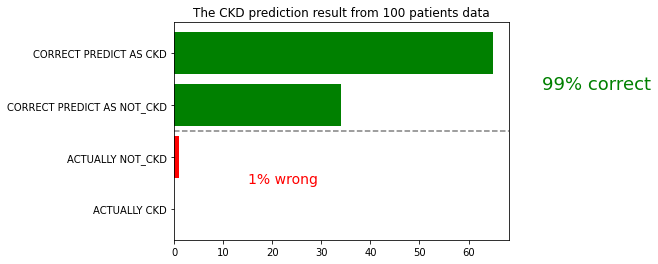

In [259]:
# Plot bar horizontal
plt.barh(result.index, result.values,color = ['red','red','green','green'],)
plt.axhline(1.5,color='black',linestyle = '--',alpha= 0.5)
plt.title('The CKD prediction result from 100 patients data')
plt.text(x= 75, y = 2.3, s = '99% correct',size=18,color = 'green')
plt.text(x = 15 , y= 0.5 , s = '1% wrong' , size =14 ,color = 'red');


### From the prediction result from the final model, I would suggest to use this model. Because of the accuracy of the model is 99% that predict correct and also this model can reduce the number of predicting preson with CKD at 100% accuration. Eventhough there will be one person to predict wrong, but this would not cost much negative effect to the hospital which need highest reliability to predict the CKD disease.